If running on Google Colab uncomment here:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-geometric
!pip install lifelines

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=0fdc3e425650515ca7afa2c72b70a2dee5d243fd28fa6161eefc2f2e693d4fcb
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric
     ━━━

In [97]:

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
from torch.utils.data import Dataset, Sampler
import torch.utils.data as data_utils
from torchvision import datasets, transforms
from copy import deepcopy
from numpy.random import randn
from torch.nn import BatchNorm1d
from torch.nn import Sequential, Linear, ReLU,Tanh,LeakyReLU,ELU,SELU,GELU
from torch_geometric.nn import GINConv,GATConv,EdgeConv, PNAConv,DynamicEdgeConv,global_add_pool, global_mean_pool, global_max_pool
import time
from tqdm import tqdm
from scipy.spatial import distance_matrix, Delaunay
import random
from torch_geometric.data import Data, DataLoader
import pickle
from glob import glob
import os
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from sklearn.model_selection import StratifiedKFold
import pdb
from statistics import mean, stdev
from glob import glob
import os
import pandas as pd
import numpy as np
import pickle
from torch.autograd import Variable
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from sklearn.model_selection import StratifiedKFold, train_test_split
import math
from random import shuffle
from itertools import islice
from lifelines.utils import concordance_index as cindex
from lifelines import KaplanMeierFitter
from sklearn.model_selection import StratifiedShuffleSplit
from collections import OrderedDict
import re
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.init import xavier_normal_
import operator

Set up the variables:

In [22]:
LEARNING_RATE = 0.00001
WEIGHT_DECAY = 0.0002
L1_WEIGHT = 0.001
SCHEDULER = None
BATCH_SIZE = 10
NUM_BATCHES = 2000
NUM_LOGS = 150 # How many times in training the loss value is stored

#Select what feature set to use
SHUFFLE_NET = True

VALIDATION = True
NORMALIZE = False
CENSORING = True
FRAC_TRAIN = 0.8
CONCORD_TRACK = True
FILTER_TRIPLE = False
EARLY_STOPPING = True
MODEL_PATH = 'Best_model/'
VARIABLES = 'DSS'
TIME_VAR = VARIABLES + '.time'
ON_GPU = True
USE_CUDA = torch.cuda.is_available()
rng = np.random.default_rng()
device = {True:'cuda:0',False:'cpu'}[USE_CUDA]

Accessory methods:

In [23]:

def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v

def toTensor(v,dtype = torch.float,requires_grad = True):
    return torch.from_numpy(np.array(v)).type(dtype).requires_grad_(requires_grad)

def toTensorGPU(v,dtype = torch.float,requires_grad = True):
    return cuda(torch.from_numpy(np.array(v)).type(dtype).requires_grad_(requires_grad))

def toNumpy(v):
    if type(v) is not torch.Tensor: return np.asarray(v)
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

def pickleLoad(ifile):
    with open(ifile, "rb") as f:
        return pickle.load(f)

def toGeometric(Gb,y,tt=1e-3):
    return Data(x=Gb.x, edge_index=(Gb.get(W)>tt).nonzero().t().contiguous(),y=y)

def toGeometricWW(X,W,y,tt=0):
    return Data(x=toTensor(X,requires_grad = False), edge_index=(toTensor(W,requires_grad = False)>tt).nonzero().t().contiguous(),y=toTensor([y],dtype=torch.long,requires_grad = False))


def pair_find(graphs,features):
    indexes = []
    for j in range(len(graphs)):
        graph_j = graphs[j]
        if features == 'BRCA-SHUFFLE':
            event_j = graph_j[1][0]
            time_j = graph_j[1][1]
        else:
            event_j, time_j = graph_j.event, graph_j.e_time
        if event_j == 1:
            for i in range(len(graphs)):
                graph_i = graphs[i]
                if features == 'BRCA-SHUFFLE':
                    time_i = graph_i[1][1]
                else:
                    time_i = graph_i.e_time
                if graph_j != graph_i and time_i > time_j:
                    indexes.append((i,j))
    shuffle(indexes)
    return indexes


def SplitBrcaData(dataset, numSplits, isShuffle, testSize):
    if isShuffle:
        eventVars = [dataset[i][1][0] for i in range(len(dataset))]
    else:
        eventVars = [int(dataset[i].event.detach().numpy()) for i in range(len(dataset))]
    x = np.zeros(len(dataset))
    shuffleSplit = StratifiedShuffleSplit(n_splits = numSplits, test_size = testSize, random_state=3)
    return shuffleSplit.split(x,eventVars)

def disk_graph_load(batch):
    return [torch.load(directory + '/' + graph + '.g') for graph in batch]

def get_predictions(model,graphs,model_indicator,features = 'BRCA-SHUFFLE',device=torch.device('cuda:0')) -> list:
    outputs = []
    e_and_t = []
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        for i in range(len(graphs)):
            graph = graphs[i]
            try:
                gene_data = graphs[i][1][2]
            except IndexError:
                print(f"IndexError encountered for i={i} (Testing)")
            if features == 'BRCA-SHUFFLE':
                tag = [graph[0]]
                temp = [graph[1][0], graph[1][1]]
                graph = disk_graph_load(tag)
            else:
                temp = [graph.event.item(),graph.e_time.item()]
                graph = [graph]
            size = 1
            loader = DataLoader(graph, batch_size=size)
            for d in loader:
                d = d.to(device)
            if model_indicator == 'combine':
                g_loader = DataLoader([gene_data], batch_size=size)
                for g in g_loader:
                    g = g.to(device)
                z,_,_ = model(g,d)
            else:
                z,_,_ = model(d)
            z = toNumpy(z)
            outputs.append(z[0][0])
            e_and_t.append(temp)
    return outputs, e_and_t

In [24]:
class GNN(torch.nn.Module):
    def __init__(self, dim_features, dim_target, layers=[16,16,8],pooling='max',dropout = 0.0,conv='GINConv',gembed=False,**kwargs) -> None:
        """
        Parameters
        ----------
        dim_features : TYPE Int
            DESCRIPTION. Number of features of each node
        dim_target : TYPE Int
            DESCRIPTION. Number of outputs
        layers : TYPE, optional List of number of nodes in each layer
            DESCRIPTION. The default is [6,6].
        pooling : TYPE, optional
            DESCRIPTION. The default is 'max'.
        dropout : TYPE, optional
            DESCRIPTION. The default is 0.0.
        conv : TYPE, optional Layer type string {'GINConv','EdgeConv'} supported
            DESCRIPTION. The default is 'GINConv'.
        gembed : TYPE, optional Graph Embedding
            DESCRIPTION. The default is False. Pool node scores or pool node features
        **kwargs : TYPE
            DESCRIPTION.
        Raises
        ------
        NotImplementedError
            DESCRIPTION.
        Returns
        -------
        None.
        """
        super(GNN, self).__init__()
        self.dropout = dropout
        self.embeddings_dim=layers
        self.no_layers = len(self.embeddings_dim)
        self.first_h = []
        self.nns = []
        self.convs = []
        self.linears = []
        self.pooling = {'max':global_max_pool,'mean':global_mean_pool,'add':global_add_pool}[pooling]
        self.gembed = gembed #if True then learn graph embedding for final classification (classify pooled node features) otherwise pool node decision scores

        for layer, out_emb_dim in enumerate(self.embeddings_dim):
            if layer == 0:
                self.first_h = Sequential(Linear(dim_features, out_emb_dim), BatchNorm1d(out_emb_dim),GELU())
                self.linears.append(Sequential(Linear(out_emb_dim, dim_target),GELU()))

            else:
                input_emb_dim = self.embeddings_dim[layer-1]
                self.linears.append(Linear(out_emb_dim, dim_target))
                subnet = Sequential(Linear(input_emb_dim, out_emb_dim), BatchNorm1d(out_emb_dim))
                if conv=='GINConv':
                    self.nns.append(subnet)
                    self.convs.append(GINConv(self.nns[-1], **kwargs))  # Eq. 4.2 eps=100, train_eps=False
                elif conv=='EdgeConv':
                    subnet = Sequential(Linear(2*input_emb_dim, out_emb_dim), BatchNorm1d(out_emb_dim))
                    self.nns.append(subnet)
                    self.convs.append(EdgeConv(self.nns[-1],**kwargs))#DynamicEdgeConv#EdgeConv                aggr='mean'
                elif conv=='GATConv':
                    self.nns.append(subnet)
                    self.convs.append(GATConv(input_emb_dim, out_emb_dim, heads=8, concat=False, dropout=dropout))
                else:
                    raise NotImplementedError

        self.nns = torch.nn.ModuleList(self.nns)
        self.convs = torch.nn.ModuleList(self.convs)
        self.linears = torch.nn.ModuleList(self.linears)  # has got one more for initial input

    def forward(self, data) -> torch.tensor:

        x, edge_index, batch = data.x, data.edge_index, data.batch

        out = 0
        pooling = self.pooling
        Z = 0
        for layer in range(self.no_layers):
            if layer == 0:
                x = self.first_h(x)
                z = self.linears[layer](x)
                Z+=z
                dout = F.dropout(pooling(z, batch), p=self.dropout, training=self.training)
                out += dout
            else:
                x = self.convs[layer-1](x,edge_index)
                if not self.gembed:
                    z = self.linears[layer](x)
                    Z+=z
                    dout = F.dropout(pooling(z, batch), p=self.dropout, training=self.training)
                else:
                    dout = F.dropout(self.linears[layer](pooling(x, batch)), p=self.dropout, training=self.training)
                out += dout

        return out,Z,x

In [25]:
class LinearSubNet(nn.Module):
    def __init__(self, dim_features, hidden_dims, dropout=0.0, middle_layer=0, **kwargs) -> None:
        super(LinearSubNet, self).__init__()

        self.linears = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.relus = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        input_dim = dim_features
        for hidden_dim in hidden_dims:
            linear_layer = nn.Linear(input_dim, hidden_dim)
            self.linears.append(linear_layer)

            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
            self.relus.append(nn.PReLU())
            self.dropouts.append(nn.Dropout(dropout))
            input_dim = hidden_dim

        self.middle_layer = middle_layer

    def forward(self, x):
        middle_output = None
        output = x

        for i in range(len(self.linears)):
            output = self.linears[i](output)
            output = self.batch_norms[i](output)
            output = self.relus[i](output)
            output = self.dropouts[i](output)

            if i == self.middle_layer:
                middle_output = output.clone()

        return output, middle_output

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dims):
        super(Autoencoder, self).__init__()

        layers = []
        input_size = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_size, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.PReLU())
            input_size = hidden_dim
        layers.append(nn.Linear(input_size, encoding_dim))
        self.encoder = nn.Sequential(*layers)

        layers = []
        input_size = encoding_dim
        for hidden_dim in reversed(hidden_dims):
            layers.append(nn.Linear(input_size, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.PReLU())
            input_size = hidden_dim
        layers.append(nn.Linear(input_size, input_dim))
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

class GeneWithAE(nn.Module):
    def __init__(self, ae_input_dim, gene_hidden, middle_layer):
        super(GeneWithAE, self).__init__()

        hidden_dims = [round(ae_input_dim * 0.75), round(ae_input_dim * 0.5)]
        self.ae = Autoencoder(ae_input_dim, ae_input_dim // 2, hidden_dims)
        self.gene = LinearSubNet(ae_input_dim // 2, gene_hidden, dropout=0.3, middle_layer=middle_layer)

    def forward(self, data):
        encoded, decoded = self.ae(data)
        gene_output, middle_output = self.gene(encoded)
        return gene_output, decoded, middle_output

In [17]:
class LMF(nn.Module):
    def __init__(self, gene_in, graph_in, hidden_dims, dropouts, output_dim, rank):

        super(LMF, self).__init__()

        self.gene_in = gene_in
        self.graph_in = graph_in

        self.gene_hidden = hidden_dims[0]
        self.graph_hidden = hidden_dims[1]
        self.output_dim = output_dim
        self.rank = rank

        self.gene_prob = dropouts[0]
        self.graph_prob = dropouts[1]
        self.post_fusion_prob = dropouts[2]

        self.gene_subnet = GeneWithAE(self.gene_in, self.gene_hidden,0)
        self.graph_subnet = GNN(dim_features=self.graph_in,
                               dim_target = self.graph_hidden[-1], layers = self.graph_hidden[:-1], pooling = 'mean',
                               dropout = 0.0, conv='EdgeConv', aggr = 'max')

        self.post_fusion_dropout = nn.Dropout(p=self.post_fusion_prob)
        self.gene_factor = Parameter(torch.Tensor(self.rank, self.gene_hidden[-1] + 1, self.output_dim))
        self.graph_factor = Parameter(torch.Tensor(self.rank, self.graph_hidden[-1] + 1, self.output_dim))
        self.fusion_weights = Parameter(torch.Tensor(1, self.rank))
        self.fusion_bias = Parameter(torch.Tensor(1, self.output_dim))

        # init teh factors
        xavier_normal_(self.gene_factor)
        xavier_normal_(self.graph_factor)
        xavier_normal_(self.fusion_weights)
        self.fusion_bias.data.fill_(0)
        self.relu = nn.PReLU()

    def forward(self, gene_x, graph_x):

        gene_h,decoded_gene,_ = self.gene_subnet(gene_x)
        graph_h, _,_ = self.graph_subnet(graph_x)
        batch_size = gene_h.data.shape[0]

        if gene_h.is_cuda:
            DTYPE = torch.cuda.FloatTensor
        else:
            DTYPE = torch.FloatTensor

        _gene_h = torch.cat((Variable(torch.ones(batch_size, 1).type(DTYPE), requires_grad=False), gene_h), dim=1)
        _graph_h = torch.cat((Variable(torch.ones(batch_size, 1).type(DTYPE), requires_grad=False), graph_h), dim=1)

        fusion_gene = torch.matmul(_gene_h, self.gene_factor)
        fusion_graph = torch.matmul(_graph_h, self.graph_factor)
        fusion_zy = fusion_gene * fusion_graph

        output = torch.matmul(self.fusion_weights, fusion_zy.permute(1, 0, 2)).squeeze() + self.fusion_bias
        output = output.view(-1, self.output_dim)
        output = self.relu(output)

        return output, [decoded_gene],0

In [62]:
class second_fusion(nn.Module):
    def __init__(self, gene_in, graph_in, hidden_dims, dropouts, LMF_output_dim, rank, middle_layers, share_hidden_dim):
        super(second_fusion, self).__init__()

        self.gene_in = gene_in
        self.graph_in = graph_in

        self.gene_middle = middle_layers[0]
        self.graph_middle = middle_layers[1]

        self.gene_hidden = hidden_dims[0]
        self.graph_hidden = hidden_dims[1][:middle_layers[1]+1]
        self.graph_encoder_hidden = hidden_dims[1][middle_layers[1]+1:]

        self.share_hidden_dims = share_hidden_dim

        self.output_dim = LMF_output_dim
        self.rank = rank

        self.gene_prob = dropouts[0]
        self.graph_prob = dropouts[1]
        self.post_fusion_prob = dropouts[2]

        self.gene_subnet = GeneWithAE(self.gene_in,self.gene_hidden, self.gene_middle)
        self.graph_subnet = GNN(dim_features=self.graph_in,
                               dim_target = self.graph_hidden[-1], layers = self.graph_hidden[:-1],
                               dropout = graph_prob, pooling = 'mean', conv='EdgeConv', aggr = 'max')
        self.graph_encoder = Autoencoder(self.graph_hidden[-1],self.graph_encoder_hidden[-1],self.graph_encoder_hidden[0:-1])

        self.gene_share_encoder = LinearSubNet(dim_features=self.gene_hidden[self.gene_middle], hidden_dims=self.share_hidden_dims,
                                              dropout=self.gene_prob, middle_layer=0)
        self.graph_share_encoder = LinearSubNet(dim_features=self.gene_hidden[self.gene_middle], hidden_dims=self.share_hidden_dims,
                                              dropout=self.gene_prob, middle_layer=0)

        self.post_fusion_dropout = nn.Dropout(p=self.post_fusion_prob)
        self.gene_factor = Parameter(torch.Tensor(self.rank, self.share_hidden_dims[-1] + 1, self.output_dim))
        self.graph_factor = Parameter(torch.Tensor(self.rank, self.share_hidden_dims[-1] + 1, self.output_dim))
        self.fusion_weights = Parameter(torch.Tensor(1, self.rank))
        self.fusion_bias = Parameter(torch.Tensor(1, self.output_dim))

        # init teh factors
        xavier_normal_(self.gene_factor)
        xavier_normal_(self.graph_factor)
        xavier_normal_(self.fusion_weights)
        self.fusion_bias.data.fill_(0)

        self.final_linear = nn.Linear(3, 1)
        self.relu = nn.PReLU()

    def forward(self, gene_x, graph_x):

        gene_h,decoded_gene,middle_output_gene = self.gene_subnet(gene_x)
        middle_output_graph, _,_ = self.graph_subnet(graph_x)
        graph_h,decoded_graph = self.graph_encoder(middle_output_graph)
        encoded_graph = middle_output_graph.clone()

        middle_output_gene,_ = self.gene_share_encoder(middle_output_gene)
        middle_output_graph,_ = self.graph_share_encoder(middle_output_graph)
        batch_size = middle_output_graph.data.shape[0]

        if gene_h.is_cuda:
            DTYPE = torch.cuda.FloatTensor
        else:
            DTYPE = torch.FloatTensor

        _gene_h = torch.cat((Variable(torch.ones(batch_size, 1).type(DTYPE), requires_grad=False), middle_output_gene), dim=1)
        _graph_h = torch.cat((Variable(torch.ones(batch_size, 1).type(DTYPE), requires_grad=False), middle_output_graph), dim=1)

        fusion_gene = torch.matmul(_gene_h, self.gene_factor)
        fusion_graph = torch.matmul(_graph_h, self.graph_factor)
        fusion_zy = fusion_gene * fusion_graph

        output = torch.matmul(self.fusion_weights, fusion_zy.permute(1, 0, 2)).squeeze() + self.fusion_bias
        output = output.view(-1, self.output_dim)

        concatenated_h = torch.cat((gene_h,graph_h,output), dim=1)
        output = self.final_linear(concatenated_h)
        output = self.relu(output)

        return output, [decoded_gene,decoded_graph,encoded_graph], [middle_output_gene, middle_output_graph, gene_h, graph_h]

In [88]:
class NetWrapper:
    def __init__(self, model, device='cuda:0',features='BRCA-CC',model_indicator = 'graph', encoder = 'True', m = 0) -> None:
        self.model = model
        self.device = torch.device(device)
        self.features = features
        self.model_indicator = model_indicator
        self.encoder = encoder
        self.m = m

    def loss_fn(self,batch,gene_tensors,optimizer,time,censor) -> float:
        z = toTensorGPU(0)
        censor = torch.tensor(censor, dtype=torch.float32).to(device)
        loss = []
        l2_loss = 0.0
        # This can be changed when using a system with large RAM
        if self.features == 'BRCA-SHUFFLE':
            graph_set = list(set(batch))
            graphs = disk_graph_load(graph_set)
        batch_load = DataLoader(graphs, batch_size = len(graphs))
        for d in batch_load:
            d = d.to(self.device)
        if self.model_indicator == 'combine':
            gene_tensors = DataLoader(gene_tensors, batch_size = len(gene_tensors))
            for e in gene_tensors:
                e = e.to(self.device)

        self.model.train()
        optimizer.zero_grad()
        if self.model_indicator == 'combine':
            output,decoded,fusion_parameter = self.model(e, d)
            #output,_ = self.model(e)
        else:
            output,_,_ = self.model(d)

        current_batch_len = len(batch)
        R_mat = np.zeros([current_batch_len, current_batch_len], dtype=int)
        for i in range(current_batch_len):
            for j in range(current_batch_len):
                R_mat[i,j] = time[j] >= time[i]
        R_mat = torch.FloatTensor(R_mat).to(device)
        theta = output.reshape(-1)
        exp_theta = torch.exp(theta)
        survival_loss = -torch.mean((theta - torch.log(torch.sum(exp_theta*R_mat, dim=1))) * censor)
        survival_loss = survival_loss / current_batch_len

        if self.encoder == 'True':
            if self.model_indicator == 'combine' and self.m == 0:
                # Reconstruction losses
                recon_loss_gene = F.mse_loss(decoded[0], e)
                # Combine everything
                loss = survival_loss + recon_loss_gene

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1)
                optimizer.step()
                return [loss.item(),survival_loss.item(),recon_loss_gene.item(),0,0]

            else:
                # Reconstruction losses
                recon_loss_gene = F.mse_loss(decoded[0], e)
                recon_loss_graph = F.mse_loss(decoded[1],decoded[2])
                #Similarity loss
                similarity_loss = F.mse_loss(fusion_parameter[0], fusion_parameter[1])
                # Combine everything
                loss = survival_loss + 0.5*(recon_loss_gene + recon_loss_graph) + similarity_loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1)
                optimizer.step()
                return [loss.item(),survival_loss.item(),recon_loss_gene.item(),recon_loss_graph.item(),similarity_loss.item()]
        else:
            loss = survival_loss
            loss.backward()
            optimizer.step()
            return loss.item()

    def censor_data(self,graphs, censor_time): # The censor time measured in years
        cen_time = 365 * censor_time
        for graph in graphs:
            if self.features == 'BRCA-SHUFFLE':
                time = graph[1][1]
            else:
                time = graph.e_time
            if time > cen_time:
                if self.features == 'BRCA-SHUFFLE':
                    graph[1] = (0,cen_time,graph[1][2])
                else:
                    graph.event = toTensor(0)
                    graph.e_time = toTensor(cen_time)
            else:
                continue
        return graphs

    def train(self,training_data,validation_data,max_batches=200,num_logs=50,optimizer=torch.optim.Adam,
              early_stopping = 0, return_best = False, batch_size = 10,num_epochs=10) -> float:
            return_best = return_best and validation_data is not None
            log_interval = max_batches // num_logs
            loss_vals = {}
            loss_vals['train'] = []
            loss_vals['validation'] = []

            concords = []
            c_best = 0.5
            best_model = deepcopy(self.model)
            for epoch in tqdm(range(num_epochs)):
                if self.model_indicator == 'combine':
                    losses = [0,0,0,0,0]
                else:
                    losses = 0
                for i in range(0, len(training_data), batch_size):
                    batch_pairs = []
                    gene_tensors = []
                    time = []
                    censor = []
                    if i + batch_size < len(training_data):
                        for j in range(i, i + batch_size):
                            graph_i = training_data[j][0]
                            gene_i = training_data[j][1][2]
                            time_i = training_data[j][1][1]
                            censor_i = training_data[j][1][0]
                            batch_pairs.append(graph_i)
                            gene_tensors.append(gene_i)
                            time.append(time_i)
                            censor.append(censor_i)
                        loss = self.loss_fn(batch_pairs,gene_tensors,optimizer,time,censor)
                        if self.model_indicator == 'combine':
                            losses = list(map(operator.add, losses, loss))
                        else:
                            losses += loss

                loss_vals['train'].append(losses)

                eval = Evaluator(self.model,model_indicator=self.model_indicator,device='cuda:0',features='BRCA-SHUFFLE')
                concord = eval.test_evaluation(validation_data)
                concords.append(concord)

            return loss_vals, concords, self.model




In [20]:

class Evaluator:
    def __init__(self, model, model_indicator, device='cuda:0',features = 'BRCA-SHUFFLE') -> None:
        self.model = model
        self.device = device
        self.features = features
        self.model_indicator = model_indicator

    def get_predictions(self,model,graphs,device=torch.device('cuda:0')) -> list:
        outputs = []
        e_and_t = []
        model.eval()
        with torch.no_grad():
            for i in range(len(graphs)):
                graph = graphs[i]
                if self.features == 'BRCA-SHUFFLE':
                    tag = [graph[0]]
                    temp = [graph[1], graph[1]]
                    graph = disk_graph_load(tag)
                else:
                    temp = [graph.event.item(),graph.e_time.item()]
                    graph = [graph]
                size = 1
                loader = DataLoader(graph, batch_size=size)
                for d in loader:
                    d = d.to(device)
                z = model(d)
                z = toNumpy(z)
                outputs.append(z[0])
                e_and_t.append(temp)
        return outputs, e_and_t

    def test_evaluation(self,testDataset):
        predictions, e_and_t = get_predictions(self.model,testDataset,self.model_indicator,self.features)
        T = [x[1] for x in e_and_t]
        E = [x[0] for x in e_and_t]
        concord = 1 - cindex(T,predictions,E)
        return concord

    def K_M_Curves(self, graphs, split_val, mode = 'Train') -> None:
        outputs, e_and_t = get_predictions(self.model,graphs,self.features)
        T = [x[1] for x in e_and_t]
        E = [x[0] for x in e_and_t]
        mid = np.median(outputs)
        if mode != 'Train':
            if split_val > 0:
                mid = split_val
        else:
            print(mid)
        T_high = []
        T_low = []
        E_high = []
        E_low = []
        for i in range(len(outputs)):
          if outputs[i] <= mid:
            T_high.append(T[i])
            E_high.append(E[i])
          else:
            T_low.append(T[i])
            E_low.append(E[i])
        km_high = KaplanMeierFitter()
        km_low = KaplanMeierFitter()
        ax = plt.subplot(111)
        ax = km_high.fit(T_high, event_observed=E_high, label = 'High').plot_survival_function(ax=ax)
        ax = km_low.fit(T_low, event_observed=E_low, label = 'Low').plot_survival_function(ax=ax)
        from lifelines.plotting import add_at_risk_counts
        add_at_risk_counts(km_high, km_low, ax=ax)
        plt.title('Kaplan-Meier estimate')
        plt.ylabel('Survival probability')
        plt.show()
        plt.tight_layout()
        from lifelines.statistics import logrank_test
        results = logrank_test(T_low, T_high, E_low, E_high)
        print("p-value %s; log-rank %s" % (results.p_value, np.round(results.test_statistic, 6)))

In [12]:

if __name__ == '__main__':
    device = {True:'cuda:0',False:'cpu'}[USE_CUDA]
    import pandas as pd
    import os
    from natsort import natsorted
    # This is set up to run on colab vvv
    survival_file = r'drive/MyDrive/SlideGraph/NIHMS978596-supplement-1.xlsx'
    #gene_file = pd.read_csv('drive/MyDrive/SlideGraph/topics_brca_dawood.csv')
    gene_file = pd.read_excel('drive/MyDrive/SlideGraph/656Genes_data.xlsx')
    gene_file.set_index(gene_file.columns[0], inplace=True)
    columns_to_drop = ['ER', 'PR', 'HER2', 'OS', 'OSTime', 'PFI', 'PFITime', 'DSS', 'DSSTime']
    gene_file = gene_file.drop(columns=columns_to_drop)
    # Log-transform the whole dataset
    gene_file = gene_file.applymap(lambda x: np.log(1 + x))
    # Z-score normalization for each column (each gene across all patients)
    gene_file = (gene_file - gene_file.mean()) / gene_file.std()
    # Define a function to categorize each column
    def categorize_column(col):
        upper_threshold = col.mean() + 1 * col.std()
        lower_threshold = col.mean() - 1 * col.std()
        return col.apply(lambda x: 1 if x > upper_threshold else (-1 if x < lower_threshold else 0))
    # Apply the function to each column in gene_file
    gene_file = gene_file.apply(categorize_column)
    cols2read = [VARIABLES,TIME_VAR]
    TS = pd.read_excel(survival_file).rename(columns= {'bcr_patient_barcode':'ID'}).set_index('ID')  # path to clinical file
    TS = TS[cols2read][TS.type == 'BRCA']
    # Conditionally set TIME_VAR
    TS.loc[TS[TIME_VAR] >= 3650, TIME_VAR] = 3650
    if SHUFFLE_NET:
        bdir = r'drive/MyDrive/SlideGraph/ShuffleNet_0.8_dth_4K/'
        # Set up directory for on disk dataset
        directory = r'drive/MyDrive/SlideGraph/Graphs'
        try:
            os.mkdir(directory)
        except FileExistsError:
            pass
    Exid = 'Slide_Graph CC_feats'
    graphlist = glob(os.path.join(bdir, "*.pkl"))#[0:100]
    device = 'cuda:0'
    cpu = torch.device('cpu')

    if FILTER_TRIPLE:
        filter_file = 'drive/MyDrive/SlideGraph/TCGA-BRCA-DX_CLINI (8).xlsx'
        cols = ['ERStatus','PRStatus','HER2FinalStatus']
        db = pd.read_excel(filter_file).rename(columns= {'CompleteTCGAID':'ID'}).set_index('ID')
        db = db[cols]

    try:
        os.mkdir(MODEL_PATH)
    except FileExistsError:
        pass
    graphlist = natsorted(graphlist)
    dataset = []
    from tqdm import tqdm
    for graph in tqdm(graphlist):
        TAG = os.path.split(graph)[-1].split('_')[0][:12]
        status = TS.loc[TAG,:][1]
        event, event_time = TS.loc[TAG,:][0], TS.loc[TAG,:][1]

        gene = gene_file.loc[TAG]
        gene = torch.tensor(gene.to_numpy(), dtype=torch.float)

        if np.isnan(event):
            continue
        if SHUFFLE_NET:
            G = pickleLoad(graph)
            # Google Colab may sometimes produce "Transport endpoint is not connected" error here
            # This is not a bug in the code. Rerunning the cell will fix this.
            G.to('cpu')
            gene.to('cpu')
        else:
            if USE_CUDA:
                G = pickleLoad(graph)
                G.to('cpu')
                gene.to('cpu')
            else:
                G = torch.load(graph, map_location=device)
        try:
            G.y = toTensorGPU([int(status)], dtype=torch.long, requires_grad = False)
        except ValueError:
            continue
        W = radius_neighbors_graph(toNumpy(G.coords), 1500, mode="connectivity",include_self=False).toarray()
        g = toGeometricWW(toNumpy(G.x),W,toNumpy(G.y))
        g.coords = G.coords
        g.event = toTensor(event)
        g.e_time = toTensor(event_time)
        if SHUFFLE_NET:
            dataset.append([TAG,(event,event_time,gene)])
            torch.save(g,directory+'/'+TAG+'.g')
        else:
            dataset.append(g)
print(len(dataset))

100%|██████████| 652/652 [10:00<00:00,  1.09it/s]

639


In [91]:
trainingDataset = dataset.copy()
event_vector = np.array([int(g[1][0]) for g in trainingDataset])

folds = 5
models = []

from tqdm import tqdm

if SHUFFLE_NET:
    G = torch.load(directory + f'/{dataset[0][0]}.g')
else:
    G = dataset[0]

converg_vals = []
fold_concord = []
eval_metrics = []
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.1

'''Change to either graph or combine for different network'''
indicator = 'combine'

for train_index, vali_index in SplitBrcaData(trainingDataset,folds,SHUFFLE_NET,0.2):
    # get indices for training and testing
        trainingDataset = dataset.copy()
    # Set up model and optimizer

        '''Remove the # in the model, net for testing LMF network'''
        model = LMF(gene_in = len(dataset[0][1][2]), graph_in = G.x.shape[1],
                    hidden_dims = [[24,24,16,16,4], [24,24,16,16,4]], dropouts = [0.5,0.5,0.5],
                    output_dim = 1, rank = 2)
        net = NetWrapper(model,device = device,features = 'BRCA-SHUFFLE', model_indicator=indicator, encoder='True',m=0)

        '''Remove the # in the model, net for testing second fusion network'''
        #model = second_fusion(gene_in = len(dataset[0][1][2]), graph_in = G.x.shape[1],
        #            hidden_dims = [[24,24,16,16,1], [24,24,16,16,1]], dropouts = [0.5,0.5,0.5],
        #            LMF_output_dim = 1, rank = 2, middle_layers=[2,2], share_hidden_dim=[16,16,4])
        #net = NetWrapper(model,device = device,features = 'BRCA-SHUFFLE', model_indicator=indicator, encoder='True',m=1)
        '''Remove the # in the model, net for testing GNN network'''
        #model = GNN(dim_features=G.x.shape[1],
        #            dim_target = 1, layers = [64,32,16,16],
        #            dropout = 0.0, pooling = 'mean', conv='EdgeConv', aggr = 'max')
        #net = NetWrapper(model,device = device,features = 'BRCA-SHUFFLE', model_indicator=indicator, encoder='False')

        model = model.to(device)
        optimizer = optim.Adam(model.parameters(),
                        lr=LEARNING_RATE,
                        weight_decay=WEIGHT_DECAY,
                        betas=(0.9, 0.999))
        x_train = [trainingDataset[i] for i in train_index]
        testDataset = [trainingDataset[i] for i in vali_index]
        # Only censoring the test data
        # x_val = net.censor_data(x_val,10)
        losses, concords, BestModel, = net.train(x_train,testDataset,optimizer = optimizer,return_best = True,max_batches = NUM_BATCHES,num_epochs=50)
        models.append(BestModel)
        converg_vals.append(losses)
        fold_concord.append(concords)
        #m = max(concords)
        eval_metrics.append(concords[-1])
        print(concords[-1])

avg_c = mean(eval_metrics)
stdev_c = stdev(eval_metrics)

print(f"Performance on test data over {folds} folds:")
print(f"{avg_c} +/- {stdev_c}")
print(f"perf on each split was: {eval_metrics}")

100%|██████████| 25/25 [04:22<00:00, 10.49s/it]


0.6711915535444948


100%|██████████| 25/25 [04:25<00:00, 10.63s/it]


0.7028231797919762


100%|██████████| 25/25 [04:25<00:00, 10.61s/it]


0.7634271099744245


100%|██████████| 25/25 [04:24<00:00, 10.60s/it]


0.6330845771144278


100%|██████████| 25/25 [04:21<00:00, 10.45s/it]

0.7915360501567398
Performance on test data over 5 folds:
0.7124124941164126 +/- 0.06509045140865043
perf on each split was: [0.6711915535444948, 0.7028231797919762, 0.7634271099744245, 0.6330845771144278, 0.7915360501567398]


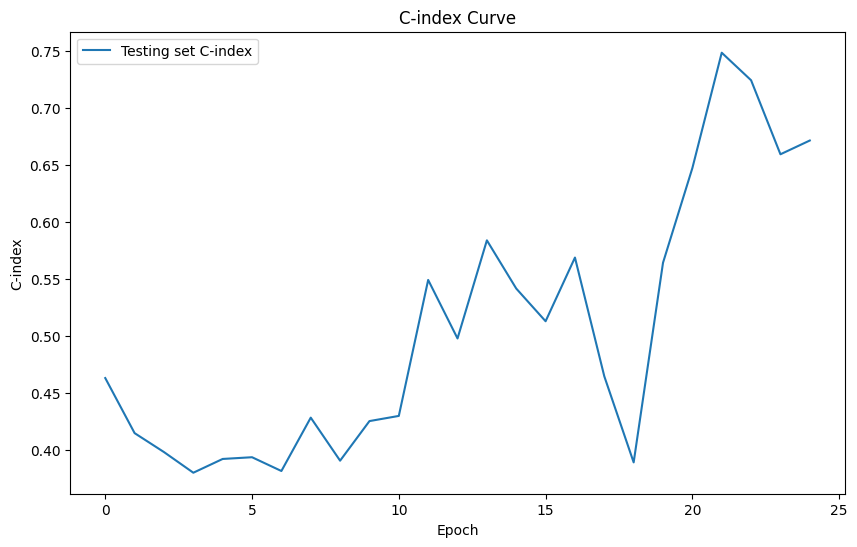

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(fold_concord[0], label='Testing set C-index')
plt.xlabel('Epoch')
plt.ylabel('C-index')
plt.title('C-index Curve')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(converg_vals[0]['train'], label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
training_data = losses['train']
# Extracting only the loss values from the training data
loss_values = [x[0] for x in training_data]

# Generating epoch or iteration numbers based on the length of training data
epochs = range(1, len(training_data)+1)

# Specifying the labels for each metric
labels = ['Total Loss', 'Survival Loss', 'Genetic Recovery Loss', 'Graph Recovery Loss', 'Similarity Loss','L2 Loss']

# Extracting each set of metrics and plotting them
for i in range(len(training_data[0])-1):
    metric_values = [x[i] for x in training_data]
    plt.plot(epochs, metric_values, label=labels[i])

plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title('Training losses Over Time')
plt.legend()

plt.show()
